# Preparação

In [1]:
#Importa as bibliotecas necessárias
import requests
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

C:\Users\m_hen\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
#Cria um dataframe com os dados já coletados
df = pd.read_csv("Insira o caminho do dataset aqui", ',')
#No scrapping dos dados, a tabela de origem assinala um '-' para dados vazios.  
df = df.replace('-',0) 
#Visualiza os tipos de dados de cada coluna
df.dtypes

Unnamed: 0               int64
partidas                object
minutos                  int64
gols                    object
assistencias            object
chutes                  object
passes-chave            object
dribles                 object
faltas_sofridas         object
impedimentos            object
desarmes_sofridos       object
dominios_errados        object
nota                   float64
posicao                 object
idade                    int64
nome                    object
time                    object
desarmes                object
interceptacoes          object
faltas_cometidas        object
impedimentos_ganhos     object
afastadas_perigo        object
dribles_sofridos        object
Blocks                  object
gols_contra             object
passes_chave            object
passes                  object
perc_passes             object
cruzamentos             object
bolas_longas            object
enfiadas                object
dtype: object

In [62]:
#A coluna 'passes-chave' está duplicada. Além disso, a primeira coluna não está nomeada. Vamos avaliar do que se trata
df.head()

Unnamed: 0 partidas  minutos gols assistencias chutes passes-chave dribles  \
0           0        2      180    0            0    0.5            1       0   
1           1    11(3)      927    1            6    2.1          1.9     2.9   
2           2        3      270    0            1      0          0.3       0   
3           3        1       90    0            0      0            0       0   
4           4    21(3)     1905   11            5    2.3          1.3     1.9   

  faltas_sofridas impedimentos  ... afastadas_perigo dribles_sofridos  Blocks  \
0               0            0  ...              9.5                0     3.5   
1             2.3          0.1  ...              0.1              0.9     0.1   
2             0.3            0  ...             10.0                1     0.7   
3               0            0  ...              3.0                0       0   
4             2.4          0.4  ...              1.0              0.7       0   

  gols_contra  passes_chave passes perc_passes cruzamentos bolas_longas  \
0           0             1   27.5        80.0           0          3.0   
1           0           1.9   45.4        82.7         1.5          2.3   
2           0           0.3   27.7        72.3           0          3.0   
3           0             0   22.0        50.0           0          2.0   
4           0           1.3   22.9        74.5           0          0.3   

  enfiadas  
0      0.5  
1      0.4  
2        0  
3        0  
4      0.1  

[5 rows x 31 columns]

In [4]:
#Define o índice das colunas que vão permanecer no dataframe
colunas_corretas = [15,14,13,12,16,11] + list(range(1,6)) + list(range(7,11)) + list(range(17,df.shape[1]))

#Elimina as colunas 'Unnamed: 0' e a primeira 'passes-chave'
df = df.iloc[:,colunas_corretas]

#Remove colunas que não fazem parte da análise
df_clust = df.drop(columns=['partidas', 'posicao', 'nota', 'idade', 'nome', 'time'])
df_clust.shape

(1513, 23)

In [6]:
#Converte as colunas para tipo float para análise dos algoritmos
for coluna in range(23):
    df_clust.iloc[:,coluna] = df_clust.iloc[:,coluna].astype(float)
    
#Visualiza os tipos de dados de cada coluna
df_clust.dtypes

dominios_errados       float64
minutos                float64
gols                   float64
assistencias           float64
chutes                 float64
dribles                float64
faltas_sofridas        float64
impedimentos           float64
desarmes_sofridos      float64
desarmes               float64
interceptacoes         float64
faltas_cometidas       float64
impedimentos_ganhos    float64
afastadas_perigo       float64
dribles_sofridos       float64
Blocks                 float64
gols_contra            float64
passes_chave           float64
passes                 float64
perc_passes            float64
cruzamentos            float64
bolas_longas           float64
enfiadas               float64
dtype: object

# Limpeza de Dados

In [7]:
#Cria uma matriz que permite visualizar a corelação entre as variáveis
matriz_corr = df_clust.corr()
#Evidencia as correlações entre as variáveis que são maiores do que 0,7 (forte correlação)
matriz_corr[matriz_corr > 0.7].sum()[matriz_corr[matriz_corr > 0.7].sum()>1]

dominios_errados     1.706779
desarmes_sofridos    1.706779
passes_chave         1.734709
cruzamentos          1.734709
dtype: float64

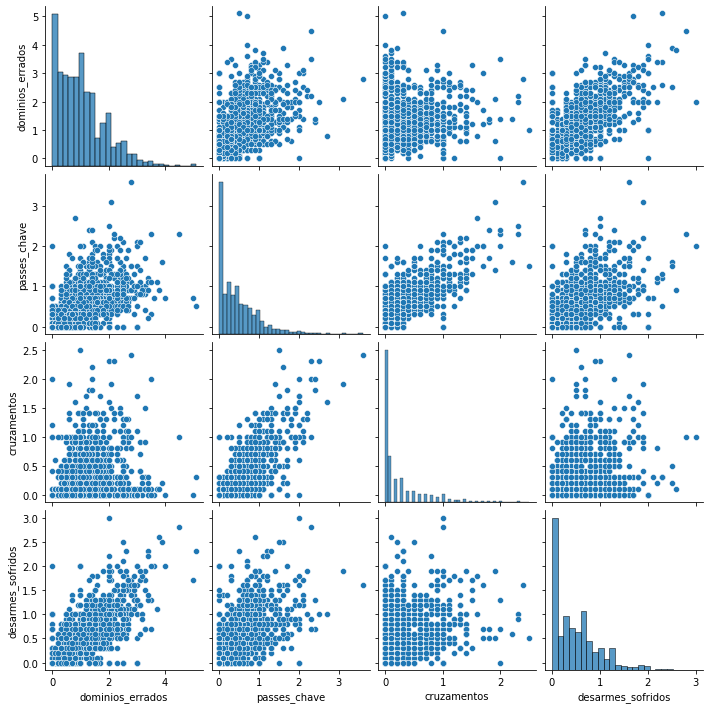

In [8]:
#Cruzamentos e passes-chave podem estar correlacionados
#Domínios errados e desarmes sofridos podem estar correlacionados
#Vamos visualizar em gráficos qual é exatamente o comportamento dessas variáveis

#Importa a biblioteca seaborn para visualização de gráficos
import seaborn as sns
#Plota a distribuição de cada par de variáveis
sns.pairplot(df_clust[['dominios_errados','passes_chave', 'cruzamentos', 'desarmes_sofridos']])

In [9]:
#passes-chave e cruzamentos realmente parecem estar correlacionados (passes-chave será priorizado por englobar cruzamentos)
#domínios errados e desarmes sofridos realmente parecem estar correlacionados (desarmes sofridos será priorizado por ser 
#mais amplo que domínios errados)

#Apaga colunas que possuem forte correlação com outras
df_clust.drop(columns = ['dominios_errados', 'cruzamentos'], inplace = True)
df_clust.shape

(1513, 21)

In [10]:
#Gols e assistências estão com números gerais. É preciso converter para números por jogo (média a cada 90 minutos)
df_clust['gols'] = df_clust['gols']/(df_clust['minutos']/90)
df_clust['assistencias'] = df_clust['assistencias']/(df_clust['minutos']/90)
#Remove a coluna "minutos", agora que não é mais necessária
df_clust.drop(columns = 'minutos', inplace = True)
#Gols contra são muito raros, dependem mais do aleatório do que dos próprios jogadores, sendo assim, serão retirados também
df_clust.drop(columns = 'gols_contra', inplace = True)

df_clust.shape

(1513, 19)

# Normalização dos dados

In [11]:
#Importa o módulo necessário para normalização dos dados
from sklearn import preprocessing

#Instancia e normaliza os dados
min_max_scaler = preprocessing.MinMaxScaler()
df_normal = min_max_scaler.fit_transform(df_clust)

# Ajuste e avaliação do modelo

In [12]:
#Importa o módulo necessário para avaliar os modelos de clusterização
from sklearn import metrics

#Cria um dicionário para guardar os valores das avaliações de cada modelo
analise_kmeans = {}

#Cria uma faixa de cluster que variará de 30 até 105, para que possamos comparar qual valor melhor se encaixa aos nossos dados
faixa_clusters = [5*i for i in range(6,30)]

#Cria uma função que ajusta o modelo e calcula as métricas de avaliação
def algoritmo_clust(k,dataset):    

    #Instancia o modelo a ser utilizado: "K-Means"
    kmeans = KMeans(n_clusters=k, random_state=132) #random state para inicializar sempre no mesmo local
    
    #Categoriza cada entrada, retornando uma label
    labels = kmeans.fit_predict(dataset)

    #Define as métricas de avaliação de modelo
    
    #Silhouete significa que os elementos são próximos entre si dentro de seus clusters, e distantes dos elementos de 
    #outros clusters. Varia de -1 a 1 (quanto maior, melhor)
    silhouette = metrics.silhouette_score(dataset, labels, metric='euclidean')
    #Davies-Boudin indica a similaridade e dissimilaridade entre os clusters. Quanto menor, mais separados estão os 
    #cluster e menos os elementos de um mesmo cluster distoam entre si
    dbs = metrics.davies_bouldin_score(dataset, labels)
    #Calinsk-Harabaz indica a distribuição das distâncias entre os clusters (quanto maior, melhor)
    ch = metrics.calinski_harabasz_score(dataset, labels)

    #Retorna um dicionário contendo as métricas de avaliação do modelo
    return {'silhouette' : silhouette, 'dbs': dbs, 'ch': ch}

#Executa a função anterior para cada item da faixa de clusters criada
for k in faixa_clusters:
    analise_kmeans [k] = algoritmo_clust(k, df_normal)
    
    

In [13]:
#Cria um dataframe com os dados resultantes para que possamos avaliar melhor cada modelo
pd.DataFrame(analise_kmeans).transpose().sort_values(by ='silhouette', ascending = False)

silhouette       dbs          ch
30     0.107449  1.845671  117.226052
35     0.106083  1.737366  105.316586
45     0.105497  1.825692   88.396127
40     0.102634  1.890839   95.487226
50     0.102143  1.755940   82.851505
55     0.098799  1.786675   77.824324
140    0.098579  1.484669   44.357223
75     0.098570  1.652927   64.783481
70     0.098483  1.735749   67.364545
60     0.097882  1.791040   74.309619
65     0.097648  1.778058   70.673112
105    0.097571  1.603124   52.249519
80     0.097319  1.667195   62.185100
135    0.097269  1.517194   45.177919
145    0.096403  1.513674   43.488870
90     0.096390  1.633661   57.287657
130    0.096330  1.517265   46.509670
100    0.096187  1.657347   53.480448
85     0.096062  1.644583   59.354678
95     0.095406  1.670568   55.211455
125    0.094970  1.538781   47.620730
110    0.094750  1.590146   50.903953
120    0.094341  1.563416   48.635925
115    0.094018  1.562170   49.792322

In [14]:
#Percebemos que por volta de k=30 os nossos indicadores da clusterização se tornam melhores. Vamos repetir o procedimento
#para valores próximos a essa faixa

#Cria um dicionário para guardar os valores das avaliações de cada modelo
analise_kmeans = {}
#Cria uma faixa de cluster que variará de 30 até 46, para que possamos comparar qual valor melhor se encaixa aos nossos dados
faixa_clusters = [i for i in range(30,46)]
#Executa a função "algoritmo_clust" para cada item da faixa de clusters criada
for k in faixa_clusters:
    analise_kmeans [k] = algoritmo_clust(k, df_normal)

In [15]:
#Cria um dataframe com os dados resultantes para que possamos avaliar melhor cada modelo
pd.DataFrame(analise_kmeans).transpose().sort_values(by ='silhouette', ascending = False)

silhouette       dbs          ch
41    0.108546  1.836854   94.143588
36    0.107465  1.768325  103.873784
30    0.107449  1.845671  117.226052
31    0.106579  1.857696  114.471245
35    0.106083  1.737366  105.316586
45    0.105497  1.825692   88.396127
43    0.105295  1.866271   90.650466
44    0.105167  1.826444   89.808836
42    0.105121  1.840242   92.487485
39    0.103635  1.820872   97.339639
40    0.102634  1.890839   95.487226
32    0.102520  1.879915  111.331511
34    0.101906  1.783394  106.724347
33    0.101802  1.882293  109.199709
37    0.100229  1.779318  101.856948
38    0.098258  1.813360   99.259299

In [25]:
#Ao que parece, k=30 realmente é o mais adequado para nossa clusterização

#Vamos utilizar então o KMeans com esse valor
kmeans = KMeans(n_clusters=30, random_state=132) #random state para inicializar sempre no mesmo local

#Instancia as labels geradas pelo modelo
labels = kmeans.fit_predict(df_normal)

#Associa essas labels ao dataframe original
df['labels_kmeans'] = labels

In [17]:
#Investigaremos agora o perfil de cada cluster. Antes disso, é interessante padronizarmos as posições dos jogadores
#por setores do campo/função. Vamos avaliar quais as variações existentes em nosso dataset
print(df['posicao'].unique(), '\n\n Número de posições diferentes: ', len(df['posicao'].unique()))

['Midfielder' 'AM(CLR),FW' 'Defender' 'GK' 'AM(LR)' 'AM(CR)' 'M(CLR)'
 'AM(CL),FW' 'Goalkeeper' 'Forward' 'D(R),M(R)' 'D(C)' 'AM(LR),FW' 'D(L)'
 'D(L),M(CLR)' 'AM(CLR)' 'M(CL)' 'DMC' 'D(L),M(L)' 'D(R),M(CLR)'
 'D(C),DMC' 'D(CL)' 'D(CR),DMC' 'M(CR)' 'AM(L)' 'FW' 'AM(R)' 'AM(C),FW'
 'D(L),M(CL)' 'D(C),M(C)' 'D(R)' 'D(R),DMC' 'AM(CL)' 'M(C)' 'M(CLR),FW'
 'D(CL),DMC' 'D(R),M(CR)' 'M(C),FW' 'D(CR)' 'D(LR),M(R)' 'D(L),M(CR)'
 'M(LR)' 'D(CLR),M(R)' 'AM(CR),FW' 'D(R),DMC,M(R)' 'D(L),DMC,M(L)' 'AM(C)'
 'DMC,M(R)' 'AM(R),FW' 'AM(L),FW' 'M(L)' 'D(L),M(LR)' 'M(CL),FW'
 'D(L),M(C)' 'D(R),M(C)' 'D(CLR)' 'D(CL),DMC,M(L)' 'D(CR),M(R)'
 'D(LR),M(L)' 'D(CL),M(L)' 'M(R)' 'D(L),DMC' 'DMC,M(L)' 'D(LR)'] 

 Número de posições diferentes:  64


In [18]:
#Inicialmente, podemos substituir as posições escritas por extenso
posicoes = {'Defender':'Zagueiro',  'Midfielder':'Meia', 'Goalkeeper':'Goleiro', 'Forward':'Atacante'}

#Cria uma função para fazermos isso
def substitui_posicoes (antiga_posicao):
    
    #Valida se a posição é escrita por extenso
    if antiga_posicao in posicoes:
        #Define a nova posição a partir do dicionário criado
        nova_posicao = posicoes[antiga_posicao]
    else:
        #Mantém a posição original
        nova_posicao = antiga_posicao
        
    return nova_posicao

#Cria uma nova coluna, que conterá as posições padronizadas
df['posicao_padronizada'] = list(map(substitui_posicoes,df['posicao']))

In [19]:
#Agora, há jogadores que jogam em mais de uma posição. Vamos tomar como base apenas uma, a primeira que aparece na
#descrição original

#Realiza a segmentação e seleciona o primeiro elemento da lista resultante
df['posicao_padronizada'] = df['posicao_padronizada'].apply(lambda posicao: posicao.split(',')[0])

#Visualizando detalhes da nova coluna
print(df['posicao_padronizada'].unique(), '\n\n Número de posições diferentes: ', len(df['posicao_padronizada'].unique()))

['Meia' 'AM(CLR)' 'Zagueiro' 'GK' 'AM(LR)' 'AM(CR)' 'M(CLR)' 'AM(CL)'
 'Goleiro' 'Atacante' 'D(R)' 'D(C)' 'D(L)' 'M(CL)' 'DMC' 'D(CL)' 'D(CR)'
 'M(CR)' 'AM(L)' 'FW' 'AM(R)' 'AM(C)' 'M(C)' 'D(LR)' 'M(LR)' 'D(CLR)'
 'M(L)' 'M(R)'] 

 Número de posições diferentes:  28


In [20]:
#Define um dicionário para padronização das posições
posicoes = {'D':'Zagueiro','FW':'Atacante','GK':'Goleiro','AM':'Meia Avançado','M':'Meia', 'DMC':'Volante'}

#Cria uma função para isso
def define_posicao (posicao_antiga):
    
    #Valida se a posição principal está no dicionário criado
    if posicao_antiga.split('(')[0] in posicoes:
        #Define a nova posição com base no dicionário criado
        posicao_nova = posicoes[posicao_antiga.split('(')[0]]
    else:
        posicao_nova = posicao_antiga
    
    #Valida se o jogador é um lateral
    if (posicao_antiga.split('(')[0] == 'D') and ('C' not in  posicao_antiga.split('(')[1]):
        posicao_nova = 'Lateral'
        
    #Valida se o jogador é um ponta
    if (posicao_antiga.split('(')[0] == 'AM') and ('C' not in  posicao_antiga.split('(')[1]):
        posicao_nova = 'Ponta'
        
    return posicao_nova

#Ajusta a nova coluna criada para conter as posições padronizadas
df['posicao_padronizada'] = list(map(define_posicao,df['posicao_padronizada']))

#Visualizando detalhes da nova coluna
print(df['posicao_padronizada'].value_counts(), '\n\n Número de posições diferentes: ', len(df['posicao_padronizada'].unique()))

Zagueiro         316
Meia             275
Atacante         234
Lateral          196
Meia Avançado    151
Volante          125
Ponta            119
Goleiro           97
Name: posicao_padronizada, dtype: int64 

 Número de posições diferentes:  8


In [26]:
#Agora sim, vamos avaliar os clusters criados. Uma boa maneira de identificar se fazem sentido é verificar
#quantas posições diferentes estão em cada cluster

#Percorre todas as labels
for i in range(30):    
    
    print('Label',i,'\nNº posições:',len(df[df['labels_kmeans']==i]['posicao_padronizada'].unique()),         
          '\nNº jogadores:', len(df[df['labels_kmeans']==i]),'\nPosições:',         
          df[df['labels_kmeans']==i]['posicao_padronizada'].unique(), '\n\n')

Label 0 
Nº posições: 4 
Nº jogadores: 56 
Posições: ['Volante' 'Lateral' 'Zagueiro' 'Meia'] 


Label 1 
Nº posições: 6 
Nº jogadores: 82 
Posições: ['Ponta' 'Meia' 'Atacante' 'Meia Avançado' 'Zagueiro' 'Lateral'] 


Label 2 
Nº posições: 1 
Nº jogadores: 54 
Posições: ['Zagueiro'] 


Label 3 
Nº posições: 4 
Nº jogadores: 24 
Posições: ['Meia Avançado' 'Ponta' 'Lateral' 'Meia'] 


Label 4 
Nº posições: 2 
Nº jogadores: 50 
Posições: ['Goleiro' 'Zagueiro'] 


Label 5 
Nº posições: 5 
Nº jogadores: 22 
Posições: ['Atacante' 'Meia Avançado' 'Meia' 'Ponta' 'Lateral'] 


Label 6 
Nº posições: 6 
Nº jogadores: 44 
Posições: ['Atacante' 'Lateral' 'Meia' 'Meia Avançado' 'Volante' 'Zagueiro'] 


Label 7 
Nº posições: 5 
Nº jogadores: 62 
Posições: ['Meia Avançado' 'Ponta' 'Atacante' 'Lateral' 'Meia'] 


Label 8 
Nº posições: 8 
Nº jogadores: 70 
Posições: ['Goleiro' 'Zagueiro' 'Atacante' 'Lateral' 'Volante' 'Meia Avançado'
 'Meia' 'Ponta'] 


Label 9 
Nº posições: 1 
Nº jogadores: 1 
Posições:

In [ ]:
'''
O objetivo do projeto aqui é explorar a capacidade do algoritmo em separar os jogadores de acordo com
seu desempenho nos fundamentos principais do jogo. É interessante observar que as labels 2 e 18 contém exclusivamente
Há ainda outras labels que agregam jogadores que atuam em faixas do campo muito parecidas, como 1, 6, 11, 15, 20, 23, 
25 e 29. 

Levando em consideração que os fundamentos elegidos para análise não descrevem bem a posição de goleiro, é notável que
haja uma label exclusivamente dedicada a essa posição.

Claramente há labels com poucos jogadores que a compões. Talvez diminuir o parâmetro 'k' do modelo fosse interessante.
Por outro lado, há apenas 3 labels assim, 11, 24 e 27, que totalizam apenas 15 jogadores de nosso dataset (cerca de 1%).
Ou seja, foi possível enquadrar praticamente todos os jogadores das ligas brasileira e argentina em alguma categoria.

De forma geral, podemos assumir que os jogadores agregados possuem PERFIL parecido, independentemente de suas posições.
Isso é útil para táticas que não possuem estruturas rígidas, por exemplo. Afinal, ao perder uma peça importante, é possível
buscar outra com desempenho e perfil semelhantes, talvez até com um custo benefício maior.

Como forma de aprimoramento, poderíamos, no início do tratamento dos dados, separar as posições e aplicar exatamente os
mesmos passos deste projeto a cada uma. Assim poderíamos segmentar da forma tradicional os jogadores de acordo com suas
POSIÇÕES e pontos fortes/fracos

'''

In [27]:
df.to_csv('dataset_com_labels.csv',index=False)